In [69]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

In [70]:
df_2024 = pd.read_parquet('Futures_2024.parquet', engine='pyarrow')
df_2023 = pd.read_parquet('Futures_2023.parquet', engine='pyarrow')

In [71]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
df.index = pd.to_datetime(df.index)
filter1 = df.dropna(axis=1, thresh=138428)
filter2 = filter1.loc[:, (df != 0).all(axis=0)]
base_df = filter2.resample('D',origin='2023-01-02 09:16:00').first().dropna()

In [72]:
df_nifty= pd.read_parquet('Idx_fut.parquet', engine='pyarrow')
df_nifty = df_nifty[[col for col in df_nifty if 'NIFTY_Close' in col]]
df_nifty.index = pd.to_datetime(df_nifty.index)
df_nifty = df_nifty[df_nifty.index > '2023-01-02 09:16:00']
nifty_frame = df_nifty.resample('D',origin='2023-01-02 09:16:00').first().dropna()
nifty_frame.drop(columns = 'BANKNIFTY_Close', inplace=True)
nifty_frame = nifty_frame[nifty_frame.index <'2024-07-02 15:30:00']

In [73]:
rel_prices = base_df.div(nifty_frame['NIFTY_Close'], axis=0)

In [74]:
nifty_50 = ["MARUTI_Close", "ITC_Close", "M&M_Close", "TITAN_Close", "EICHERMOT_Close", "HEROMOTOCO_Close", "SBIN_Close", "HINDUNILVR_Close", "TATAMOTORS_Close", "LT_Close", "ICICIBANK_Close", "BAJAJFINSV_Close", "HDFCLIFE_Close", "SBILIFE_Close", "JSWSTEEL_Close", "HINDALCO_Close", "ASIANPAINT_Close", "ADANIPORTS_Close", "HDFCBANK_Close", "COALINDIA_Close", "TCS_Close", "INFY_Close", "NTPC_Close", "AXISBANK_Close", "APOLLOHOSP_Close", "TATASTEEL_Close", "BHARTIARTL_Close", "ADANIENT_Close", "INDUSINDBK_Close", "TECHM_Close", "KOTAKBANK_Close", "BAJFINANCE_Close", "BPCL_Close", "SHRIRAMFIN_Close", "RELIANCE_Close", "ONGC_Close"]
stock_prices = base_df[nifty_50]
relative_prices = rel_prices[nifty_50]
full_price_data = filter2[nifty_50]

In [75]:
multiplier = pd.read_csv('instrument_list.csv')
multiplier = multiplier.drop(columns=[col for col in multiplier.columns if col not in ['name', 'segment', 'lot_size']])
multiplier_nfo = multiplier[multiplier['segment'] == 'NFO-FUT']
filtered_df = multiplier_nfo.drop_duplicates(subset='name', keep='first')
valid_stocks = filtered_df['name'].unique()
valid_stock_columns = [f"{stock}_Close" for stock in valid_stocks]
columns_to_keep = [col for col in valid_stock_columns if col in stock_prices.columns]
filtered_price_df = stock_prices[columns_to_keep]
filtered_stock_names = [col.split('_')[0] for col in filtered_price_df.columns]
filtered_multiplier_df = filtered_df[filtered_df['name'].isin(filtered_stock_names)]
filtered_multiplier_df.drop(columns = 'segment', inplace=True)
filtered_multiplier_df.set_index('name', inplace=True)
filtered_multiplier_df.columns = ['mult']
mult_list = filtered_multiplier_df
mult_list.index = mult_list.index + '_Close'

C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\984550555.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_multiplier_df.drop(columns = 'segment', inplace=True)


In [76]:
class PortfolioMomentumStrategy:
    def __init__(self, stock_prices, full_price_data, relative_prices, mult, lookback_period, num_stocks, max_positions, initial_capital=200000000):
        self.stock_prices = stock_prices
        self.relative_prices = relative_prices
        self.full_price_data = full_price_data
        self.mult = mult
        self.max_positions = max_positions
        self.lookback_period = lookback_period
        self.num_stocks = int(min(max_positions // 2, num_stocks))
        self.available_capital = initial_capital
        self.current_positions = {stock: 0 for stock in stock_prices.columns}
        self.pnl_series = pd.Series(index = stock_prices.index)
        self.trade_log = []
        self.exit_log = []
        self.transaction_costs_rate = 0.0011
        self.position_exposure_matrix = pd.DataFrame(index=stock_prices.index, columns=stock_prices.columns)
        

    def calculate_momentum(self, data, current_time):
        lookback_time = current_time - pd.Timedelta(days=self.lookback_period)
        if lookback_time in data.index:
            return (data.loc[current_time]/ data.loc[lookback_time] - 1)  # Returns the momentum between now and that time
        else:
            return pd.Series(np.nan, index=data.columns) #In cases of large lookback period
    
    def rank_stocks(self, current_time):
        momentum_scores = self.calculate_momentum(self.relative_prices, current_time)
        ranked_stocks = momentum_scores.sort_values(ascending = False) #Ranks stocks top to bottom of momentum in the time period
        return ranked_stocks
    
    def allocate_positions(self, ranked_stocks, current_prices):
        top_stocks = ranked_stocks.head(self.num_stocks)
        bottom_stocks = ranked_stocks.tail(self.num_stocks)


        long_value = self.available_capital / 2
        short_value = self.available_capital / 2 #Assign half capital to long, half to short

        max_exp_per_stock = 10000000

        long_positions = {}  #To track which stocks we go long and short on and the position size
        short_positions = {}

        #So we don't repeatedly buy/sell if a stock remains in the top/bottom n stocks
        top_stocks = [stock for stock in top_stocks.index if self.current_positions[stock] == 0]
        bottom_stocks = [stock for stock in bottom_stocks.index if self.current_positions[stock] == 0]

        #Tracks total positions, i.e number of stocks in our portfolio
        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)


        long_gross_exposure = 0
        for stock in top_stocks:
            if total_positions < self.max_positions:
                position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), long_value / (current_prices[stock] * self.mult.loc[stock].values)))
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values
                if position_cost <= long_value:
                    long_positions[stock] = position_size
                    long_value -= position_cost
                    long_gross_exposure += position_cost
                    total_positions += 1
                    if position_size > 0:
                        self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'long', 'size': position_size, 'cost': position_cost[0], 'trading price': current_prices[stock], 'trade_type' : 'entry', 'multiplier': self.mult.loc[stock].values[0]})
                    

       
        short_gross_exposure = 0
        for stock in bottom_stocks:
            if total_positions < self.max_positions and short_gross_exposure < long_gross_exposure:
                remaining_short_exposure = long_gross_exposure - short_gross_exposure
                position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), remaining_short_exposure / (current_prices[stock] * self.mult.loc[stock].values)))
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values
                if position_cost <= short_value:
                    short_positions[stock] = position_size
                    short_value -= position_cost
                    short_gross_exposure += position_cost
                    total_positions += 1
                    if position_size > 0:
                        self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'short', 'size': position_size, 'cost': position_cost[0], 'trading price': current_prices[stock], 'trade_type' : 'entry', 'multiplier': self.mult.loc[stock].values[0]})

        for stock, position in long_positions.items():
            if long_gross_exposure > short_gross_exposure:
                adjustment_value = long_gross_exposure - short_gross_exposure
                adjustment_size = int(min(position, adjustment_value / (current_prices[stock] * self.mult.loc[stock].values)))
                if adjustment_size > 0:
                    long_positions[stock] -= adjustment_size
                    long_gross_exposure -= adjustment_size * current_prices[stock] * self.mult.loc[stock].values
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'long', 'size': -adjustment_size, 'cost': -adjustment_size * current_prices[stock] * self.mult.loc[stock].values[0], 'trading price': current_prices[stock], 'trade_type': 'entry', 'multiplier': self.mult.loc[stock].values[0]})
                    
        for stock, position in short_positions.items():
            if long_gross_exposure > short_gross_exposure:
                adjustment_value = long_gross_exposure - short_gross_exposure
                adjustment_size = int(min(position, adjustment_value / (current_prices[stock] * self.mult.loc[stock].values)))
                if adjustment_size > 0:
                    short_positions[stock] -= adjustment_size
                    long_gross_exposure -= adjustment_size * current_prices[stock] * self.mult.loc[stock].values
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'long', 'size': -adjustment_size, 'cost': -adjustment_size * current_prices[stock] * self.mult.loc[stock].values[0], 'trading price': current_prices[stock], 'trade_type': 'entry', 'multiplier': self.mult.loc[stock].values[0]})
                    
                    

        
        return long_positions, short_positions  


    def update_positions(self, long_positions, short_positions, previous_prices, current_prices):

        liquidated_pnl = 0
        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)

        #If stocks move out of the top and bottom n, the position is closed and we calculate the pnl of the close

        for stock in self.current_positions:
            if stock not in long_positions and stock not in short_positions:
                if self.current_positions[stock] != 0:
                    liquidated_pnl = self.current_positions[stock] * (current_prices[stock] - previous_prices[stock]) * self.mult.loc[stock].values
                    total_positions -= 1

                    self.exit_log.append({'date': current_prices.name, 'stock': stock, 'position': ' Closing long' if self.current_positions[stock] > 0 else ' Closing short',
                                        'size': abs(self.current_positions[stock]),
                                        'cost': abs(self.current_positions[stock]) * previous_prices[stock] * self.mult.loc[stock].values[0],
                                        'trading price': current_prices[stock],
                                        'trade_type': 'exit', 'multiplier': self.mult.loc[stock].values[0]})
                    
                    
                    self.current_positions[stock] = 0
                    

        #Current_positions tracks the stocks in our portfolio and the position size
        
        for stock, position in long_positions.items():
            self.current_positions[stock] = position

        for stock, position in short_positions.items():
            self.current_positions[stock] = -position

        return liquidated_pnl
    
    def update_position_exposure_matrix(self, current_time):
        current_prices = self.stock_prices.loc[current_time]
        for stock, position in self.current_positions.items():
            #exposure = position * current_prices[stock] * self.mult.loc[stock].values[0]
            self.position_exposure_matrix.at[current_time, stock] = position
  
    #Simple function to track pnl

    def calculate_pnl(self, long_positions, short_positions, previous_prices, current_prices):
        pnl = 0

        for stock, position in self.current_positions.items():
            price_change = current_prices[stock] - previous_prices[stock]
            pnl += position * price_change * self.mult.loc[stock].values + self.update_positions(long_positions, short_positions, previous_prices, current_prices)
        return pnl
    
    def calculate_transaction_costs(self, trades):
        total_transaction_costs = 0
        for trade in trades:
            turnover = trade['size'] * trade['trading price']
            total_transaction_costs += turnover * self.transaction_costs_rate
        return total_transaction_costs

    def trade(self):

        #Indexing to be able to select correct prices

        unique_dates=self.stock_prices.index
        unique_dates=unique_dates[self.lookback_period:]

        next_unique_dates=self.stock_prices.index
        next_unique_dates=next_unique_dates[self.lookback_period-1:]

        #For every day, apply the strategy
        for current_time,prev_time in zip(unique_dates,next_unique_dates):
            previous_prices = self.stock_prices.loc[prev_time]
            current_prices = self.stock_prices.loc[current_time]
            ranked_stocks = self.rank_stocks(current_time)
            long_positions, short_positions = self.allocate_positions(ranked_stocks, current_prices)
            self.update_positions(long_positions, short_positions, previous_prices, current_prices)
            pnl_raw = self.calculate_pnl(long_positions, short_positions, previous_prices, current_prices) 
            liquidated_pnl = self.update_positions(long_positions, short_positions, previous_prices, current_prices)
            pnl = pnl_raw + liquidated_pnl
            self.update_position_exposure_matrix(current_time)

            day_trades = [trade for trade in self.trade_log if trade['date'] == current_time]
            if day_trades:  
                transaction_costs = self.calculate_transaction_costs(day_trades)
                pnl -= transaction_costs
            
            self.pnl_series[current_time] = pnl

            self.available_capital += pnl 

        return pd.Series(self.pnl_series, index=self.stock_prices.index[self.lookback_period:]).cumsum(), self.position_exposure_matrix


        #Return Cumulative PnL
        


In [77]:
strategy = PortfolioMomentumStrategy(stock_prices, full_price_data, relative_prices, mult_list, 10, 5, 20)
pnl_series, position_matrix = strategy.trade()
position_matrix.dropna(inplace=True)

C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\3518891833.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), long_value / (current_prices[stock] * self.mult.loc[stock].values)))
C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\3518891833.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), remaining_short_exposure / (current_prices[stock] * self.mult.loc[stock].values)))
C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\3518891833.py:84: Dep

In [78]:
adjusted_index = full_price_data.index - pd.Timedelta(seconds=59)
full_price_data.index = adjusted_index
full_price_data = full_price_data[full_price_data.index >= '2023-01-16 09:14:00']

In [79]:
price_change = full_price_data.diff()
stock_prices_daily = stock_prices[stock_prices.index >= '2023-01-16 09:15:00']
minutely_position_matrix = pd.DataFrame(index = full_price_data.index, columns = position_matrix.columns)
for column in position_matrix.columns:
    minutely_position_matrix[column] = minutely_position_matrix[column].fillna(method='ffill')

minutely_position_matrix.update(position_matrix.reindex(minutely_position_matrix.index, method='ffill'))

minutely_price_position = minutely_position_matrix.mul(price_change)
minutely_price_position.dropna(inplace=True)

mult_df = mult_list.T
mult_df = mult_df.reindex(columns=minutely_price_position.columns)

minutely_stock_pnl = minutely_price_position * mult_df.values

minutely_pnl = minutely_stock_pnl.sum(axis=1)

initial_cap = 200000000
cumulative_minutely_pnl = minutely_pnl.cumsum()
rel_cumulative_minutely_pnl = cumulative_minutely_pnl / initial_cap

C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\3130190647.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  minutely_position_matrix[column] = minutely_position_matrix[column].fillna(method='ffill')
C:\Users\sambu\AppData\Local\Temp\ipykernel_3508\3130190647.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  minutely_position_matrix[column] = minutely_position_matrix[column].fillna(method='ffill')


In [80]:
price_change.loc['2023-01-16 15:29:00': '2023-01-17 09:16:00']

,MARUTI_Close,ITC_Close,M&M_Close,TITAN_Close,EICHERMOT_Close,HEROMOTOCO_Close,SBIN_Close,HINDUNILVR_Close,TATAMOTORS_Close,LT_Close,...,BHARTIARTL_Close,ADANIENT_Close,INDUSINDBK_Close,TECHM_Close,KOTAKBANK_Close,BAJFINANCE_Close,BPCL_Close,SHRIRAMFIN_Close,RELIANCE_Close,ONGC_Close
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-01-16 15:29:00,2.95,-0.2,1.3,-0.30,-1.30,1.25,0.1,-0.55,-0.20,-0.10,...,0.55,0.45,0.40,0.50,0.05,-3.50,0.00,-0.10,0.90,0.05
2023-01-16 15:30:00,0.00,0.0,0.0,-0.85,0.00,0.00,-0.2,0.00,-0.10,0.00,...,0.00,0.90,0.00,0.00,0.00,0.00,-0.45,0.00,0.00,0.00
2023-01-17 09:15:00,8.00,-0.2,-2.0,-7.90,0.45,-8.00,0.1,15.00,1.50,6.60,...,2.40,-20.70,-2.95,-1.40,-7.35,-21.00,0.40,-5.05,9.20,0.05
2023-01-17 09:16:00,-23.90,-0.3,-5.9,-1.95,-5.40,-4.95,-2.7,6.75,-1.15,1.55,...,-0.95,4.50,-4.45,0.35,3.70,-12.85,0.25,2.75,-1.65,0.35


In [81]:
minutely_position_matrix.loc['2023-01-16 15:29:00': '2023-01-17 09:16:00']

,MARUTI_Close,ITC_Close,M&M_Close,TITAN_Close,EICHERMOT_Close,HEROMOTOCO_Close,SBIN_Close,HINDUNILVR_Close,TATAMOTORS_Close,LT_Close,...,BHARTIARTL_Close,ADANIENT_Close,INDUSINDBK_Close,TECHM_Close,KOTAKBANK_Close,BAJFINANCE_Close,BPCL_Close,SHRIRAMFIN_Close,RELIANCE_Close,ONGC_Close
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-01-16 15:29:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-16 15:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-17 09:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-17 09:16:00,23.0,18.0,21.0,23.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-13.0,-15.0,-26.0,-16.0,-32.0


In [82]:
minutely_stock_pnl.loc['2023-04-16 15:29:00': '2023-04-17 09:16:00']

,MARUTI_Close,ITC_Close,M&M_Close,TITAN_Close,EICHERMOT_Close,HEROMOTOCO_Close,SBIN_Close,HINDUNILVR_Close,TATAMOTORS_Close,LT_Close,...,BHARTIARTL_Close,ADANIENT_Close,INDUSINDBK_Close,TECHM_Close,KOTAKBANK_Close,BAJFINANCE_Close,BPCL_Close,SHRIRAMFIN_Close,RELIANCE_Close,ONGC_Close
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-04-17 09:15:00,0.0,0.0,0.0,0.00,70061.25,-0.0,-0.0,-70395.0,-13585.0,0.0,...,0.0,-0.0,0.0,-0.0,82160.0,0.00,0.0,0.0,0.0,0.0
2023-04-17 09:16:00,-13915.0,18000.0,26565.0,38403.75,-0.00,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,-21856.25,23040.0,-34500.0,1687.5,-385.0


In [83]:
rel_cumulative_minutely_pnl.to_csv('minute_pnl_script2.csv')

In [84]:
initial_cap = 200000000

In [85]:
relative_series = pnl_series / initial_cap

In [86]:
def plot_pnl(pnl_series):
    plt.figure(figsize=(10, 6))
    pnl_series.plot()
    plt.title('Cumulative PnL')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.show()

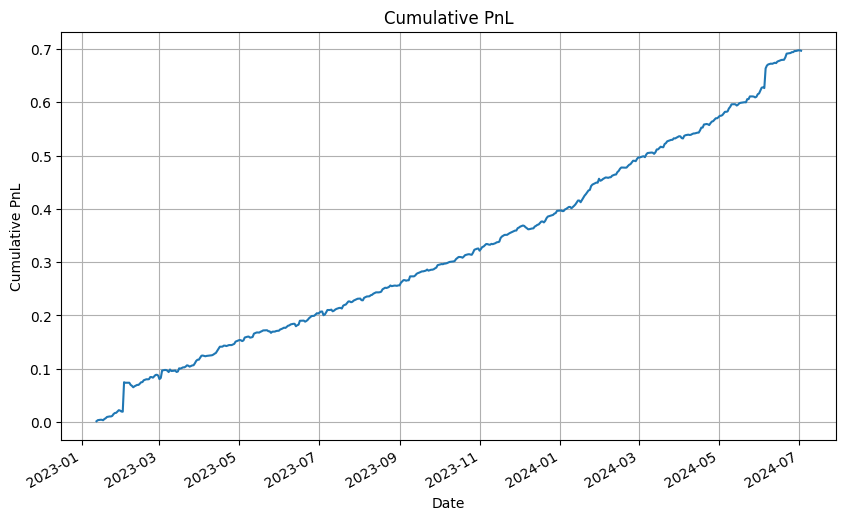

In [87]:
plot_pnl(relative_series)

In [88]:
trade_log_df = pd.DataFrame(strategy.trade_log)
exit_log_df = pd.DataFrame(strategy.exit_log)

In [89]:
full_trade_log = pd.concat([trade_log_df, exit_log_df], ignore_index=True)

full_trade_log.sort_values(by=['date', 'trade_type'], ascending=[True, False], inplace=True)


full_trade_log.reset_index(drop=True, inplace=True)

In [90]:
trade_log_final = full_trade_log.groupby(['date', 'stock', 'position'], as_index=False).agg({
        'size': 'sum',
        'cost': 'sum',
        'trading price': 'first',
        'trade_type': 'first',
        'multiplier': 'first'
    }).sort_values(by=['date', 'position'])

trade_log_final = trade_log_final[trade_log_final['size'] != 0]

In [91]:
initial_cap = 200000000
pct = 100
daily_ret = pct* (pnl_series.diff() / initial_cap)
annual_mean_returns = daily_ret.mean()*252
annial_mean_std = daily_ret.std()*np.sqrt(252)
s_r = annual_mean_returns/ annial_mean_std
print('Annual Mean Return:', annual_mean_returns,
       'Annual_Risk:', annial_mean_std,
        'Sharpe:', s_r)

Annual Mean Return: 39.11096531576535 Annual_Risk: 6.129878313362136 Sharpe: 6.380382010277401


In [92]:
minutely_position_matrix

,MARUTI_Close,ITC_Close,M&M_Close,TITAN_Close,EICHERMOT_Close,HEROMOTOCO_Close,SBIN_Close,HINDUNILVR_Close,TATAMOTORS_Close,LT_Close,...,BHARTIARTL_Close,ADANIENT_Close,INDUSINDBK_Close,TECHM_Close,KOTAKBANK_Close,BAJFINANCE_Close,BPCL_Close,SHRIRAMFIN_Close,RELIANCE_Close,ONGC_Close
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-01-16 09:15:00,0.0,0.0,21.0,-23.0,0.0,0.0,0.0,0.0,43.0,0.0,...,-27.0,0.0,0.0,0.0,0.0,-13.0,0.0,0.0,0.0,0.0
2023-01-16 09:16:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-16 09:17:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-16 09:18:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-16 09:19:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02 15:26:00,16.0,14.0,9.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.0,-18.0,-11.0,-12.0,-18.0
2024-07-02 15:27:00,16.0,14.0,9.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.0,-18.0,-11.0,-12.0,-18.0
2024-07-02 15:28:00,16.0,14.0,9.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.0,-18.0,-11.0,-12.0,-18.0
